# Homework 3

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (C): Spread and Swap Spread in November 2008

## Simplification of the setup

The date is Nov 4, 2008.

**Treasury bond**
* Suppose the Treasury bond matures exactly 30 years later, on Nov 4, 2038 rather than May 15, 2008. 
* The YTM of this freshly issued treasury is 4.193\% with a semiannual coupon of 4.25\%, same as is given in the case. (So we're just changing the maturity date to simplify things, but keeping the market data.)

**Swap**
* The fixed leg of the swap pays semiannually, with swap rate of 4.2560\%, as given in the case.
* The floating leg of the swap also pays semiannually--not quarterly--such that the payment dates are identical on both legs. Thus, it also resets the floating rate semiannually, not quarterly.
* The floating rate of the swap equals the repo rate used in the trade. Thus, these two rates cancel in the financing of the trade. (No need to consider the TED spread.) 

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
import treasury_cmds


## 1.1

List the projected cashflows on May 4, 2009, exactly six months into the trade, on the first coupon and swap date.

- The first exchange of payments of this trade exactly 6-months ahead require a fixed rate payment of 4.2560% and a floating rate payment of the prevailing yield 6-months prior to the exchange of cashflows. In this case the yield is 4.193%.


In [11]:
t_current = pd.to_datetime('2008-11-4')
t_current

Timestamp('2008-11-04 00:00:00')

In [3]:
df = {'CALDT':['2008-11-4','2008-11-4','2008-11-4'], 'TMATDT':['2038-11-4','2038-11-4','2038-11-4'],'TCOUPRT':[.04193,.04256,.0425], 'QUOTE':['Float(30-Year-Yield)','FixedSwap','30-Year-Treasury']}
df_1 = pd.DataFrame(df).set_index('QUOTE')
df_1['CALDT'] = pd.to_datetime(df_1['CALDT'])
df_1['TMATDT'] = pd.to_datetime(df_1['TMATDT'])
CF = treasury_cmds.calc_cashflows(df_1)
CF

,2009-05-04,2009-11-04,2010-05-04,2010-11-04,2011-05-04,2011-11-04,2012-05-04,2012-11-04,2013-05-04,2013-11-04,...,2034-05-04,2034-11-04,2035-05-04,2035-11-04,2036-05-04,2036-11-04,2037-05-04,2037-11-04,2038-05-04,2038-11-04
QUOTE,,,,,,,,,,,,,,,,,,,,,
Float(30-Year-Yield),0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,...,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,0.020965,100.020965
FixedSwap,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,...,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,0.021280,100.021280
30-Year-Treasury,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,...,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,0.021250,100.021250


2009-05-04     0.495551
2009-11-04     0.999316
2010-05-04     1.494867
2010-11-04     1.998631
2011-05-04     2.494182
2011-11-04     2.997947
2012-05-04     3.496235
2012-11-04     4.000000
2013-05-04     4.495551
2013-11-04     4.999316
2014-05-04     5.494867
2014-11-04     5.998631
2015-05-04     6.494182
2015-11-04     6.997947
2016-05-04     7.496235
2016-11-04     8.000000
2017-05-04     8.495551
2017-11-04     8.999316
2018-05-04     9.494867
2018-11-04     9.998631
2019-05-04    10.494182
2019-11-04    10.997947
2020-05-04    11.496235
2020-11-04    12.000000
2021-05-04    12.495551
2021-11-04    12.999316
2022-05-04    13.494867
2022-11-04    13.998631
2023-05-04    14.494182
2023-11-04    14.997947
2024-05-04    15.496235
2024-11-04    16.000000
2025-05-04    16.495551
2025-11-04    16.999316
2026-05-04    17.494867
2026-11-04    17.998631
2027-05-04    18.494182
2027-11-04    18.997947
2028-05-04    19.496235
2028-11-04    20.000000
2029-05-04    20.495551
2029-11-04    20

In [8]:
CF.loc['VSWAP',:] = CF.loc['Float(30-Year-Yield)',:]-CF.loc['FixedSwap',:]
CF.loc['CF_Trade',:] = CF.loc['VSWAP',:] + CF.loc['30-Year-Treasury',:]
# Multiply the CF by Notonal Value

CF.loc[:,'2009-05-04'].to_frame('Projected Cashflow on May 4 2009')*100

,Projected Cashflow on May 4 2009
QUOTE,
Float(30-Year-Yield),2.0965
FixedSwap,2.1280
30-Year-Treasury,2.1250
VSWAP,-0.0315
CF_Trade,2.0935


The projected cashflows are equal to this formula 6 months ahead is equal to

$V_{swap} = K freq[r_{k}(T_{i-1}, T_{t}) - c_{swap}]$

- Thus as of May 4, 2009, the value of the swap from the point of view for the fixed payer is $\$-31,500$. However, since Mills bought $\$100M$ notional of 30-year Treasury bonds with a coupon of 4.25% his net cashflow of the trade 6-months is $V_{swap} + CF_{30year_Treasury}  = \$2.0935M$



## 1.2

What is the duration of...
* the T-bond
* the swap

Remember that...
* the swap can be decomposed into a fixed-rate bond and a floating-rate note
* a floating-rate note has duration equal to the time until the next reset. Thus, at initialization, it has duration equal to 0.5 years.

Is the duration for the "paying-fixed" swap positive or negative? Is it bigger or smaller in magnitude than the T-bond?

For this problem, calculate the Macauley duration and the dollar (Macauley) duration.

<AxesSubplot:title={'center':'Dicount Factor Based off Current Yield'}>

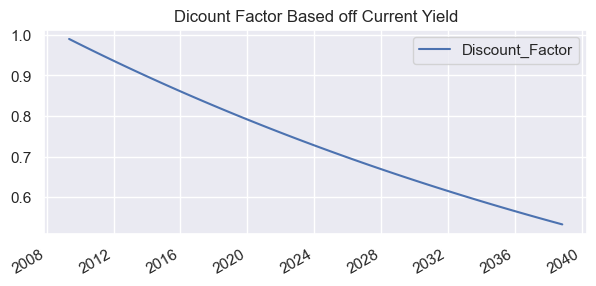

In [55]:
rate = .0419/2
maturidy_grid = pd.Series(treasury_cmds.get_maturity_delta(pd.to_datetime(CF.columns.values), t_current=t_current), index = CF.columns)
discount_factor = np.exp(-rate*maturidy_grid)
curves = pd.DataFrame(discount_factor, columns =['Discount_Factor'], index = CF.columns)
curves.plot(figsize=(7,3), title = 'Dicount Factor Based off Current Yield')

In [54]:
wts = CF.mul(curves['Discount_Factor'], axis = 1)
wts = wts.div(wts.sum(axis = 1), axis = 0)
duration = (wts @ maturidy_grid)
duration = pd.DataFrame(duration, columns = ['Duration'])
duration = duration.loc['FixedSwap':'30-Year-Treasury',:]
duration.loc['Duration_SWAP',:] = .5 - duration.loc['FixedSwap',:]
duration
# Since it is a reset date, the duration of the swap = .5 - duration of the FIXED Leg.

,Duration
QUOTE,
FixedSwap,29.715256
30-Year-Treasury,29.715648
Duration_SWAP,-29.215256


QUOTE
Float(30-Year-Yield)    101.2579
FixedSwap               101.2768
30-Year-Treasury        101.2750
VSWAP                    -0.0189
CF_Trade                101.2561
dtype: float64

## 1.3

What hedge ratio should be used to balance the notional size of the Treasury bond with the notional size of the swap, such that it is a duration-neutral position?

Specifically, if the trader enters the swap paying fixed on \$500 million notional, how large of a position should they take in the Treasury bond?

## 1.4

Suppose it is May 4, 2009, exactly six months after putting the trade on.

The spread is at -28 bps due to...
* The YTM on a new 30-year bond has risen to 4.36\%
* The swap rate on a new 30-year swap has dropped to 4.08\%

Explain conceptually how this movement impacts the components of the trade.

## 1.5

Calculate the value of the position on May 4, 2009, immediately after the first coupon and swap payments and swap reset. 

* Calculate the revised price of the Treasury bond by assuming you can apply the (May 4) 30-year YTM as a discount rate to the 29.5 year bond. (We are just using this for a rough approximation. You know that good pricing would require a discount curve, but let's not get bogged down with that here.)


* Calculate the value of the swap by decomposing it into a fixed-rate bond and a floating-rate bond.
    * The 29.5 year fixed-rate leg is priced using the (May 4) 30-year swap rate as a discount rate.
    * The floating-rate leg is priced at par given that floating-rate notes are par immediately after resets.
    
**Note**

You are being asked to calculate these valuations using the exact formula between price, cashflows, and YTM discount rate. We are not simply approximating with duration, as we already know the position was set up with zero dollar duration.

From the Discussion 1 notebook, we have this formula expressing a bond's price as a function of the coupon, $c$, and the YTM, $y_j$.

$\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align*}
$

## 1.6

Accounting for the change in value of the positions, as well as the 6-month cashflows paid on May 4, 
* what is the net profit and loss (pnl) of the position?
* what is the return on the equity capital, considering that there was a 2\% haircut (equity contribution) on the size of the initial treasury bond position.